`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
from scipy.io import loadmat
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
from scipy.io import netcdf
import netCDF4 as nc


In [2]:
haumann = loadmat('glodapv2_2016b_mapped_ppco2_gamman.mat')
lev = haumann['dpth']
gamman = haumann['gamman']
lat = haumann['lat']
lon = haumann['lon']
ppco2 = haumann['ppco2']
vol = haumann['vol']

In [3]:
PCO2 = xr.DataArray(data=ppco2,
            dims=["x", "y", "lev"],
            coords=dict(x=lon[:,0,0], 
                        y=lat[0,:,0], 
                        lev=lev[0,0,:])
            )
PCO2 = PCO2.roll(x = 20, roll_coords = True)

ndensity = xr.DataArray(data=gamman,
            dims=["x", "y", "lev"],
            coords=dict(x=lon[:,0,0], 
                        y=lat[0,:,0], 
                        lev=lev[0,0,:])
            )
ndensity = ndensity.roll(x = 20, roll_coords = True)

In [4]:
nd = ndensity.sel(x=slice(180,200)).mean(['x'],keep_attrs=True)
nd = nd.transpose('lev','y')
nd

<xarray.DataArray (lev: 33, y: 180)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ..., 29.15177,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) uint16 0 10 20 30 50 75 100 ... 3000 3500 4000 4500 5000 5500

## Let's see if we can get haumann into density space

In [46]:
ds = {}
ds['ppco2'] = PCO2
ds['gam_n'] = ndensity


from xgcm import Grid

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)
target_sig0 = np.linspace(26, 28.5, 20)

out_put = grid.transform(ds['ppco2'], 'Z', target_sig0, target_data=ds['gam_n'], method = 'linear')

/srv/conda/envs/notebook/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


In [49]:


xx = out_put.mean('x', keep_attrs = True)
xx = xx.transpose('TRANSFORMED_DIMENSION','y')
xx = xx.sel(y = slice(-70,-40))


/tmp/ipykernel_336/3629275933.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(xx.y,xx.TRANSFORMED_DIMENSION,xx)


Text(53.625, 0.5, 'Neutral Density (kg/m³)')

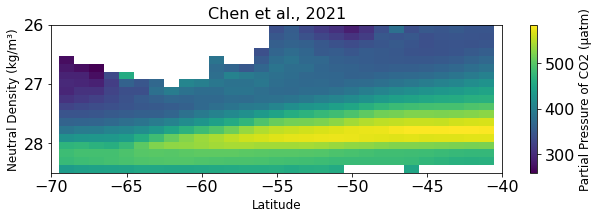

In [50]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[10,4])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 16)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 12)
plt.rc('figure', titlesize=14)

im = ax.pcolormesh(xx.y,xx.TRANSFORMED_DIMENSION,xx)
cbar = plt.colorbar(im,ax=ax)
ax.invert_yaxis()
# ax.set_yticks([26, 26.5, 27, 27.5, 28])
ax.set_xlim([-70,-40])
ax.set_xticks([-70,-65,-60,-55,-50,-45,-40])
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax.set_title('Chen et al., 2021')
ax.set_xlabel('Latitude')
ax.set_ylabel('Neutral Density (kg/m\u00b3)')

/tmp/ipykernel_329/258489649.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(d2.y, d2.lev,d2, vmin = 300, vmax = 600)


Text(63.0, 0.5, 'Depth (m)')

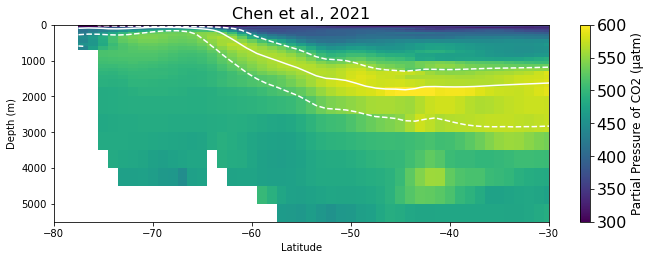

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[10,4])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 16)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 12)
plt.rc('figure', titlesize=14)


ds = PCO2.sel(x=slice(180,200)).mean(['x'],keep_attrs=True)
d2 = ds.transpose('lev','y')

ax.set_xlim([-80,-30])
# ax.set_ylim([0,1000])
im = ax.pcolormesh(d2.y, d2.lev,d2, vmin = 300, vmax = 600)
ax.contour(nd.y, nd.lev, nd, levels=[27.5, 28], colors = 'w', linestyles = 'dashed')
ax.contour(nd.y, nd.lev, nd, levels=[27.8], colors = 'w')
cbar = plt.colorbar(im,ax=ax)
ax.invert_yaxis()
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax.set_title('Chen et al., 2021')
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (m)')
# ax_idx += 1

Text(53.625, 0.5, 'Depth (m)')

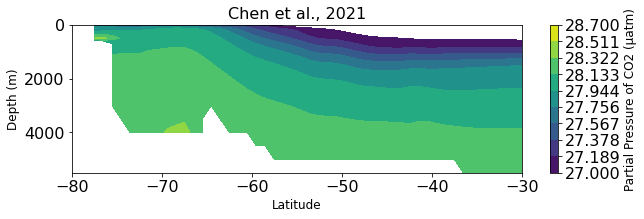

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[10,4])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 16)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 12)
plt.rc('figure', titlesize=14)



ds = ndensity.sel(x=slice(180,200)).mean(['x'],keep_attrs=True)
d2 = ds.transpose('lev','y')

ax.set_xlim([-80,-30])
im = ax.contourf(d2.y, d2.lev,d2, vmin = 27, vmax = 28.7, levels = np.linspace(27, 28.7, 10))
cbar = plt.colorbar(im,ax=ax)
ax.invert_yaxis()
cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
ax.set_title('Chen et al., 2021')
ax.set_xlabel('Latitude')
ax.set_ylabel('Depth (m)')
# ax_idx += 1

In [6]:

filename = 'MPI-SOM_FFN_SOCCOMv2018weighted_minus_4uatm_offset.nc'
nds = nc.Dataset(filename)
# ds = xr.open_dataset(filename)
times = pd.date_range('1982-01-01','2017-12-31',freq='M')
ds = xr.Dataset()
ds['fgco2'] = xr.DataArray(nds['fgco2'][:],dims=['time','lat','lon'])
ds['fgco2'] = ds['fgco2'].where(ds['fgco2']<1E19,np.nan)
# # ds['fgco2'] = ds['fgco2'].where(ds['fgco2']<1E19,0)
# # ds['seamask'] = xr.DataArray(nds['seamask'][:],dims=['lat','lon'])
ds = ds.assign_coords({'time':times,'lat':nds['lat'][:],'lon':nds['lon'][:]})

/tmp/ipykernel_329/1004965796.py:6: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  ds['fgco2'] = xr.DataArray(nds['fgco2'][:],dims=['time','lat','lon'])


In [7]:


from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds



# Creating an xgcm grid
def _degrees_to_meters(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters
        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values
        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy



gridlon='lon'
gridlat='lat'
ds = generate_grid_ds(ds, {'X':gridlon,'Y':gridlat})
xgrid = Grid(ds, periodic=['X'])

# Get horizontal distances
dlonG = xgrid.diff(ds[gridlon], 'X', boundary_discontinuity=360)
dlonC = xgrid.diff(ds[gridlon+'_left'], 'X', boundary_discontinuity=360)

dlatG = xgrid.diff(ds[gridlat], 'Y', boundary='fill', fill_value=np.nan)
dlatC = xgrid.diff(ds[gridlat+'_left'], 'Y', boundary='fill', fill_value=np.nan)

ds['dxG'], ds['dyG'] = _degrees_to_meters(dlonG, dlatG, ds[gridlon], ds[gridlat])
ds['dxC'], ds['dyC'] = _degrees_to_meters(dlonC, dlatC, ds[gridlon], ds[gridlat])

ds['daC'] = ds['dxC']*ds['dyC']


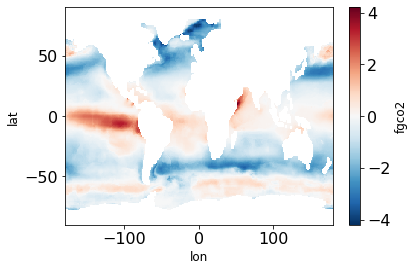

In [8]:
obs = (ds['fgco2']*ds['daC'])
# obs_fgco2= ds['fgco2'].isel(time = slice(144, 395)).mean('time', keep_attrs = True)
obs_fgco2= ds['fgco2'].mean('time', keep_attrs = True)
obs_fgco2.plot()

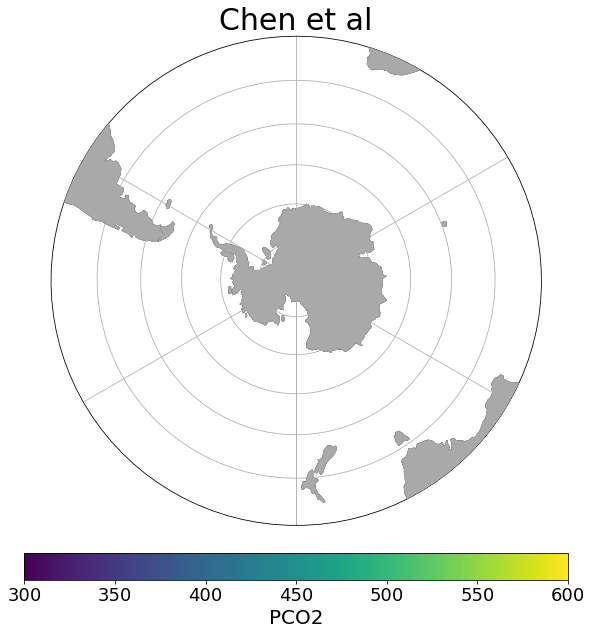

In [55]:
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize=[10,10], subplot_kw={'projection':ccrs.SouthPolarStereo()})
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.set_extent([-180, 180, -90, -30], crs_source)
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
    
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
    
ax.gridlines()
ax.coastlines()
    
title= 'Chen et al'
ax.set_title(title,fontsize=30,pad = 1)
    
lat = obs_fgco2.lat

lon = obs_fgco2.lon

X = lon
Y = lat
    
#     conversion = 3.1536e7 * 83.3
    # 3.1536e7 seconds per year
    # 83.3 mol C per kg -- 12 gC/mol
    
Z = np.swapaxes(PCO2.sel(lev = 800),0,1)
# *conversion

    
    
im = ax.pcolormesh(Z,cmap='viridis', transform = crs_source, shading = 'auto', vmin = 300, vmax = 600)
# im3 = ax.contour(X,Y,Z, transform = crs_source, levels=[0],colors='k', linewidths = 2)
cbar_label = 'PCO2'
cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
cbar.set_label(cbar_label, fontsize = 20)
cbar.ax.tick_params(labelsize=18)




In [16]:
PCO2.sel(lev = 800).transpose('y', 'x')

<xarray.DataArray (y: 180, x: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    lev      uint16 800

/tmp/ipykernel_329/317851447.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(PCO2.y, PCO2.x, pp)


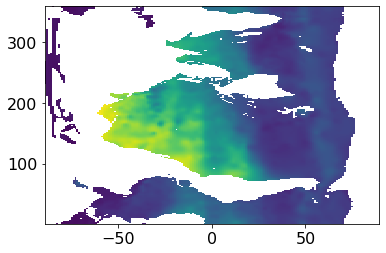

In [37]:
plt.pcolormesh(PCO2.y, PCO2.x, pp)

In [51]:
pp = np.swapaxes(p, 0, 1)
pp

<xarray.DataArray (x: 180, y: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    lev      uint16 800

In [32]:
p = PCO2.sel(lev = 800)

In [54]:
np.swapaxes(p, 0, 1)

<xarray.DataArray (x: 180, y: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    lev      uint16 800

In [38]:
PCO2

<xarray.DataArray (x: 360, y: 180, lev: 33)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) uint16 0 10 20 30 50 75 100 ... 3000 3500 4000 4500 5000 5500